In [2]:
import sys
sys.path.append("../../Chapter_3")

import pandas as pd
from transformers import AutoTokenizer, AutoModel

import torch
from torch.utils.data import WeightedRandomSampler

from tqdm.notebook import tqdm

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split

import fastai
from fastai.basics import Learner, DataLoaders
from fastai.vision.all import *
from fastai.callback.all import *

import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np

from Utils.negative_sampling import IterableProteinEmbedding, magnitude
from Utils.misc import filter_sequences_by_len_from_fasta
from Utils.encoders import SkipGramEmbedder

import warnings
warnings.filterwarnings('ignore')

# Complete RNAInter training data

In [3]:
df = pd.read_csv("../../Chapter_3/Data/TrainingData/PositiveSamples/RNAInter_small_interactions_current.csv")

def filter_out_hiv_interactions(df):
    hiv_prot_interaction = df['Species'] == 'Human immunodeficiency virus 1'
    hiv_rna_interaction = df['Also_species'] == 'Human immunodeficiency virus 1'
    return df[~(hiv_rna_interaction | hiv_prot_interaction)]

non_hiv_df = filter_out_hiv_interactions(df)
non_hiv_df

,Unnamed: 0,Interaction_ID,RNA_Name,HGNC/Entrex/Ensembl_ID,RNA_type,Species,Protein_name,NCBI_GeneID,Protein_Type,Also_species,Confidence_score,proteins,UniprotID,rnas
0,907814,RP00953369,RP11-125K10.5,ENSG00000228165,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,CACCATTCTTCAGTTATCACAGTACTGTACCTTTCAGATATACAGCATCGGTACCATGATAACCGAAAAAGGACA
1,911713,RP00957415,MIR3184,ENSG00000266919,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,GCGCGGGTTAGGAAGCAAGACTGAGGGGCCTCAGACCGAGCTTTTGGAAAATAGAAAAGTCTCGCTCTCTGCCCCTCAGCCTAACTTCCTTTAT
2,912105,RP00957817,AL365205.2,ENSG00000268745,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,CCAATGTTTCATTTCAACTGGCTTAAATCTTCAAAGTGGTTAAGAATTTAGTAAATAAAACTACTTAA
3,912866,RP00958609,RP11-717A5.2,ENSG00000273196,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,GATCATATATACTTGCATAATATCATCCCTTCCCTTGATTTCTTTCAATCTAAAAATAAATATGAGAAAAACA
4,2122927,RP02246386,RP11-717A5.2,ENSG00000273196,lncRNA,Homo sapiens,SUMO2,6613.0,TF,Homo sapiens,0.5117,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKAYCERQGLSMRQIRFRFDGQPINETDTPAQLEMEDEDTIDVFQQQTGGVY,P61956,GATCATATATACTTGCATAATATCATCCCTTCCCTTGATTTCTTTCAATCTAAAAATAAATATGAGAAAAACA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12142,8917917,RP33972761,mmu-mir-8105,MI0026035,miRNA,Mus musculus,Sumo2,170930.0,TF,Mus musculus,0.5117,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKAYCERQGLSMRQIRFRFDGQPINETDTPAQLEMEDEDTIDVFQQQTGGVY,P61957,UGCUUGAACCUGGGUCGAAGAAUCGGGGCUCGCCAGCCGACUCCUAAAGCGGAGGCGACUGGCGAGACCCGAAGAUCAGAGGGAGGAGA
12143,8923194,RP33979003,hsa-miR-24-3p,MIMAT0000080,miRNA,Homo sapiens,E7,1489079.0,protein,Human papillomavirus type 16,0.9820,MHGDTPTLHEYMLDLQPETTDLYCYEQLNDSSEEEDEIDGPAGQAEPDRAHYNIVTFCCKCDSTLRLCVQSTHVDIRTLEDLLMGTLGIVCPICSQKP,P03129,UGGCUCAGUUCAGCAGGAACAG
12144,8923201,RP33979029,hsa-miR-205-5p,MIMAT0000266,miRNA,Homo sapiens,E7,1489079.0,protein,Human papillomavirus type 16,0.9933,MHGDTPTLHEYMLDLQPETTDLYCYEQLNDSSEEEDEIDGPAGQAEPDRAHYNIVTFCCKCDSTLRLCVQSTHVDIRTLEDLLMGTLGIVCPICSQKP,P03129,UCCUUCAUUCCACCGGAGUCUG
12157,8923231,RP33979091,hsa-miR-203b-5p,MIMAT0019813,miRNA,Homo sapiens,E7,1489079.0,protein,Human papillomavirus type 16,0.9526,MHGDTPTLHEYMLDLQPETTDLYCYEQLNDSSEEEDEIDGPAGQAEPDRAHYNIVTFCCKCDSTLRLCVQSTHVDIRTLEDLLMGTLGIVCPICSQKP,P03129,UAGUGGUCCUAAACAUUUCACA


In [4]:
def generate_all_combos(list1, list2, list_limit = None):
    """
    Returns all combinations of items in two input lists
    
    ex)
    ---
    >>> x = [1,2,3]
    >>> y = ['x','y']
    >>> generate_all_combos(x,y)
    [(1, 'x'), (1, 'y'), (2, 'x'), (2, 'y'), (3, 'x'), (3, 'y')]
    """
    return [(i,j) for i in list1[:list_limit] for j in list2[:list_limit]]

In [5]:
# Load swissprot and RNAInter
# Take all protein combos

from Bio import SeqIO

SWISS_PATH = "/data/Chapter_3/Data/RawData/uniprot_sprot.fasta"
SEQ_LEN_LIMIT = 110

def reverse_key_seq_dict(swiss_dict : dict) -> dict:
    return {value : key for key,value in swiss_dict.items()}

with open(SWISS_PATH) as handle:
    # Need to have a unique ID for each seq
    swiss_id2seq = reverse_key_seq_dict({" ".join(str(record.seq)) : record.id.split('|')[1] for record in SeqIO.parse(handle, 'fasta') if len(record.seq) <= SEQ_LEN_LIMIT})
    
#     for record in :
#         if str(record.seq) not in swiss_seqs:
#             swiss_ids.append()
#             swiss_seqs.append(str(record.seq))
            
    #swiss_fasta = [(record.name, str(record.seq)) for  if len(record.seq) <= 110]

# swiss = list(set([" ".join(protein) for protein in filter_sequences_by_len_from_fasta(SWISS_PATH, 110)]))

In [6]:
class RNAInterIDConverter:
    """
    RNAInterIDConverter is designed to X
    """
    
    def __init__(self, seed):
        self.seed = seed
        self._taken_names = list()
    
    def clear_taken_names(self):
        self._taken_names = list()
    
    def get_uniprot_id_from_seq(self, df, protein_seq):
        return df[df['proteins'] == protein_seq]['UniprotID'].iloc[0]
    
    def get_random_rna_id(self, rna_names : pd.Series):
        shuffled_names = rna_names.sample(frac = 1, random_state = self.seed)
        
        for i in range(len(shuffled_names)):
            
            if shuffled_names.iloc[i] not in self._taken_names:
                name = shuffled_names.iloc[i]
                self._taken_names.append(name)
                return name
            
            # If it's the final entry, just use that
            elif i == len(shuffled_names)-1:
                return shuffled_names.iloc[i]
        
    def get_rna_id_from_seq(self, df, seq):
        self.clear_taken_names()
        rna_ids = df[df['proteins'] == seq]['RNA_Name']
        random_rna_id = self.get_random_rna_id(rna_ids)
        return random_rna_id
        
    def get_rna_and_unirpot_id_from_seq(self, df, seq):
        return (self.get_uniprot_id_from_seq(df, seq), self.get_rna_id_from_seq(df, seq))
    
    def get_unique_protein_uniprot_ids_and_rna_pair_from_df(self, df : pd.DataFrame):
        unique_seqs    = df['proteins'].unique()
        unique_protein_ids = [self.get_rna_and_unirpot_id_from_seq(df, protein_seq) for protein_seq in unique_seqs]
        return unique_protein_ids

In [7]:
class RNAInterRNACovnerter:
    """
    Generates the dictionary that converts RNA names to
    their encoded sequences
    """
    
    def encode_sequences(self, rna_seqs, embedder):
        return embedder(rna_seqs)
    
    def generate_rna_name_to_embedded_seq_converter(self, rna_names, embedded_seqs):
        return dict(zip(rna_names, embedded_seqs))
    
    def generate_rna_name_to_encoded_tensor_dict(self, rna_names, rna_seqs, embedder):
        embedded_seqs  = self.encode_sequences(rna_seqs, embedder)
        converter_dict = self.generate_rna_name_to_embedded_seq_converter(rna_names, embedded_seqs)
        return converter_dict
    
    def find_rna_seq_from_name(self, rna_name, df):
        return df[df['RNA_Name'] == rna_name]['rnas'].iloc[0]
    
    def return_rna_seqs_from_names(self, rna_names, df):
        return [self.find_rna_seq_from_name(rna_name, df) for rna_name in rna_names]
    
    def generate_rna_name_to_encoded_tensor_dict_from_df(self, rna_names, df, embedder):
        rna_seqs       = self.return_rna_seqs_from_names(rna_names, df)
        # print(list(rna_seqs))
        converter_dict = self.generate_rna_name_to_encoded_tensor_dict(rna_names, list(rna_seqs), embedder)
        return converter_dict

In [8]:
class RNAInterRNACovnerter:
    """
    Generates the dictionary that converts RNA names to
    their encoded sequences
    """
    
    def encode_sequences(self, rna_seqs, embedder):
        return embedder(rna_seqs)
    
    def generate_rna_name_to_embedded_seq_converter(self, rna_names, embedded_seqs):
        return dict(zip(rna_names, embedded_seqs))
    
    def generate_rna_name_to_encoded_tensor_dict(self, rna_names, rna_seqs, embedder):
        embedded_seqs  = self.encode_sequences(rna_seqs, embedder)
        converter_dict = self.generate_rna_name_to_embedded_seq_converter(rna_names, embedded_seqs)
        return converter_dict
    
    def find_rna_seq_from_name(self, rna_name, df):
        return df[df['RNA_Name'] == rna_name]['rnas'].iloc[0]
    
    def return_rna_seqs_from_names(self, rna_names, df):
        return [self.find_rna_seq_from_name(rna_name, df) for rna_name in rna_names]
    
    def generate_rna_name_to_encoded_tensor_dict_from_df(self, rna_names, df, embedder):
        rna_seqs       = self.return_rna_seqs_from_names(rna_names, df)
        # print(list(rna_seqs))
        converter_dict = self.generate_rna_name_to_encoded_tensor_dict(rna_names, list(rna_seqs), embedder)
        return converter_dict

In [9]:
rnainter_idconverter = RNAInterIDConverter(seed = 255)
rnainter_protein_rna_pairs = rnainter_idconverter.get_unique_protein_uniprot_ids_and_rna_pair_from_df(non_hiv_df)
uniprot2rnaname = dict(rnainter_protein_rna_pairs)

In [10]:
rnainter_rna_to_tensor_converter = RNAInterRNACovnerter()

rna_embedder_1d = SkipGramEmbedder("/data/Chapter_3/SeqEmbedders/GensimWord2Vec/RNA2Vec_1024_hidden.model", reduce = True)
rna_embedder_2d = SkipGramEmbedder("/data/Chapter_3/SeqEmbedders/GensimWord2Vec/RNA2Vec_1024_hidden.model", reduce = False, outsize = 100)

rnaname2tensor = rnainter_rna_to_tensor_converter.generate_rna_name_to_encoded_tensor_dict_from_df(uniprot2rnaname.values(), non_hiv_df, rna_embedder_1d)
rnaname2tensor_2d = rnainter_rna_to_tensor_converter.generate_rna_name_to_encoded_tensor_dict_from_df(uniprot2rnaname.values(), non_hiv_df, rna_embedder_2d)

In [11]:
class SwissIdCovnerter:
    """
    Generates the dictionary that converts Swiss names to
    their encoded sequences
    """
    
    def encode_sequences(self, rna_seqs, embedder):
        return embedder(rna_seqs)
    
    def generate_rna_name_to_embedded_seq_converter(self, rna_names, embedded_seqs):
        return dict(zip(rna_names, embedded_seqs))
    
    def generate_rna_name_to_encoded_tensor_dict(self, rna_names, rna_seqs, embedder):
        embedded_seqs  = self.encode_sequences(rna_seqs, embedder)
        converter_dict = self.generate_rna_name_to_embedded_seq_converter(rna_names, embedded_seqs)
        return converter_dict
    
    def find_rna_seq_from_name(self, rna_name, df):
        return df[df['RNA_Name'] == rna_name]['rnas'].iloc[0]
    
    def return_rna_seqs_from_names(self, rna_names, df):
        return [self.find_rna_seq_from_name(rna_name, df) for rna_name in rna_names]
    
    def generate_swiss_name_to_encoded_tensor_dict_from_df(self, rna_names, df, embedder):
        rna_seqs       = self.return_rna_seqs_from_names(rna_names, df)
        # print(list(rna_seqs))
        converter_dict = self.generate_rna_name_to_encoded_tensor_dict(rna_names, list(rna_seqs), embedder)
        return converter_dict

In [12]:
grouped_df = non_hiv_df.groupby("proteins").first()
first_values = grouped_df.reset_index()

unique_reduced_rnainter_uniprot_ids = first_values['UniprotID'].unique()
unique_proteins = list(first_values['proteins'].apply(lambda x: " ".join(x)))

print(len(unique_reduced_rnainter_uniprot_ids))
print(len(unique_proteins))

327
327


In [13]:
swiss_seqs = list(swiss_id2seq.values())

In [14]:
# proteins, tokenizer, model, chunksize, max_len, cuda = True):
model     = AutoModel.from_pretrained("Rostlab/prot_bert_bfd")
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case = False)

swiss_embedder_1d = IterableProteinEmbedding(swiss_seqs, tokenizer, model, chunksize = 3, max_len = 110, cuda = True)
swiss_embedder_2d = IterableProteinEmbedding(swiss_seqs, tokenizer, model, chunksize = 3, max_len = 110, reduce = False, cuda = True)

# Need sorted set to make a reproducable set initialization for redoing stuff
from Utils.encoders import ProtBERTEmbedder

# rnainter_prot_embedder = ProtBERTEmbedder(112,True)
# print(rnainter_prot_embedder.model.training)

rnainter_prot_embedder = IterableProteinEmbedding(unique_proteins, tokenizer, model, chunksize = 3, max_len = 110, reduce = True, cuda = True)
rnainter_prot_embedder_2d = IterableProteinEmbedding(unique_proteins, tokenizer, model, chunksize = 3, max_len = 110, reduce = False, cuda = True)

In [15]:
import os

SWISS_EMBEDDED_PATH = "../Data/EncodedData/ProtBERT_encoded_110_swissprot_1dim.pt"
SWISS_EMBEDDED_PATH_2D =  "../Data/EncodedData/ProtBERT_encoded_110_swissprot_2dim.pt"

def load_or_embed_swiss(swiss_embedder, path):
    "If swiss is already encoded, load it. If not, embed it and save the tensor for future use at specificied path"
    if not os.path.exists(path):
        with torch.no_grad():
            swiss_embedded = torch.cat([i for i in swiss_embedder])
        torch.save(swiss_embedded, path)
    else:
        swiss_embedded = torch.load(path)
    return swiss_embedded
    
    
swiss_embedded = load_or_embed_swiss(swiss_embedder_1d, SWISS_EMBEDDED_PATH)

# Do not use 2D until actually embedding Training data, not for generating
# negative samples
#swiss_embedded_2d = load_or_embed_swiss(swiss_embedder_2d, SWISS_EMBEDDED_PATH_2D)

In [16]:
# Swiss uniptot IDs linked to their corresponding tensors
swiss2tensor = dict(zip(swiss_id2seq.keys(), swiss_embedded))
# swiss2tensor_2d = dict(zip(swiss_ids_2d, swiss_embedded_2d))

In [17]:
with torch.no_grad():
    rnainter_embedded = torch.cat(list(rnainter_prot_embedder))

  0%|          | 0/109 [00:00<?, ?it/s]

In [18]:
class ComboDifferenceIterator:
    """
    
    """
    def __init__(self, seq_matrix1, seq_matrix2, model, chunksize, limit = None):
        self.seq_matrix1 = seq_matrix1
        self.seq_matrix2 = seq_matrix2
        self.model = model
        
        assert chunksize > 1, f"ComboIterator fails when chunksize is less than 2. recieved chunksize: {chunksize}"
        self.chunksize = chunksize
        self.limit = limit
    
    def _format_matrix_for_sae_diff(self, combo):
        return torch.stack(combo)
    
    def format_combos_for_sae_diff(self, combos):
        combo1, combo2 = zip(*combos)
        combo1 = self._format_matrix_for_sae_diff(combo1)
        combo2 = self._format_matrix_for_sae_diff(combo2)
        return combo1, combo2
    
    def __iter__(self):
        
        combos = generate_all_combos(self.seq_matrix1, self.seq_matrix2, list_limit = self.limit)
        
        for i in tqdm(range(0,len(combos),self.chunksize)):
            combo1, combo2 = self.format_combos_for_sae_diff(combos[i:i+self.chunksize])
            
            reduced_combo1 = self.model(combo1)
            reduced_combo2 = self.model(combo2)
            
            combo_len = len(reduced_combo1)
            
            difference_magnitude = magnitude(reduced_combo1 - reduced_combo2).reshape(combo_len, 1)
            
            yield difference_magnitude

In [19]:
SAE_DIR  = '/data/Chapter_3/Notebooks'
rna_sae  = torch.load(f"{SAE_DIR}/rnavec_encoded_aggregated_u_t_swapped_rnas_DenseSAE.pt")
prot_sae = torch.load(f"{SAE_DIR}/ProtBERT_encoded_110_swissprot_DenseSAE.pt")

In [20]:
protein_combo_iterator = ComboDifferenceIterator(rnainter_embedded, swiss_embedded.cuda(), prot_sae.cuda(), 10)

In [21]:
DIFFERENCE_MATRIX = "../Data/EncodedData/Difference_Magnitude_ProtBERT_encoded_110_swissprot_v2_and_Unique_RNAInter_Proteins.pt"

if not os.path.exists(DIFFERENCE_MATRIX):
    with torch.no_grad():
        protein_combo_magnitudes = torch.cat([i for i in protein_combo_iterator])
        torch.save(protein_combo_magnitudes, DIFFERENCE_MATRIX)
else:
    protein_combo_magnitudes = torch.load(DIFFERENCE_MATRIX)

# protein_combo_magnitudes = torch.cat([i for i in protein_combo_iterator])

In [22]:
protein_combo_magnitudes.shape

torch.Size([16812705, 1])

In [23]:
combo_ids = generate_all_combos(unique_reduced_rnainter_uniprot_ids, list(swiss_id2seq.keys()))
len(combo_ids)

16812705

In [24]:
bin_assigner = KBinsDiscretizer(n_bins=10, encode='ordinal')
bins         = bin_assigner.fit_transform(protein_combo_magnitudes.cpu()).squeeze().astype(int)

In [25]:
def plot_bin_and_diff_magnitudes(bins, protein_combo_magnitudes, ax):
    sbn.boxplot(x = bins, y = np.array( protein_combo_magnitudes.cpu().squeeze()), showfliers = False, 
                linewidth = 1.3, ax = ax)
    ax.set_ylabel("Difference magnitude")
    ax.set_xlabel("Bins")

def plot_combo_magnitude_dist(protein_combo_magnitudes, ax):
    sbn.histplot(protein_combo_magnitudes.cpu(), legend = False, ax = ax)
    ax.set_xlabel("Difference magnitude")

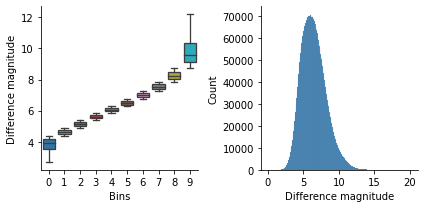

In [26]:
fig,axes = plt.subplots(1,2, figsize = (6,3))

# sbn.boxplot(x = bins, y = np.array( protein_combo_magnitudes.cpu().squeeze()), ax = axes[0])
# sbn.histplot(protein_combo_magnitudes.cpu(), legend = False, ax = axes[1])

# axes[0].set_ylabel("Difference magnitude")
# axes[0].set_xlabel("Bins")
# axes[1].set_xlabel("Difference magnitude")

plot_bin_and_diff_magnitudes(bins, protein_combo_magnitudes, axes[0])
plot_combo_magnitude_dist(protein_combo_magnitudes, axes[1])

plt.tight_layout()
sbn.despine()

plt.savefig("bin_and_diff_magnitude.png",dpi = 300)

# Sample protein pairs using difference magnitudes

In [27]:
class CustomWeightedRandomSampler(WeightedRandomSampler):
    """
    WeightedRandomSampler except allows for more than 2^24 samples to be sampled
    
    jacked from: https://github.com/pytorch/pytorch/issues/2576#issuecomment-831780307
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __iter__(self):
        rand_tensor = np.random.choice(range(0, len(self.weights)),
                                       size=self.num_samples,
                                       p=self.weights.numpy() / torch.sum(self.weights).numpy(),
                                       replace=self.replacement)
        rand_tensor = torch.from_numpy(rand_tensor)
        return iter(rand_tensor.tolist())

In [28]:
class NegativeSampleIdxGenerator():
    """
    NegativeSampleIdxGenerator is used to assign negative sample 
    indeces using assigned bins and bin weights. This is meant 
    to be used for protein difference vector magnitudes, but can 
    be applied for any dataset that is assigned into bins and
    have bin weights.Can be used on its own, but is primarily 
    intended to be used within the <TBD> class. 
    
    It has two main functions:
    
    ####################################################
    generate_negative_sample_idxs_from_sample_weights
    ####################################################
    This will generate a list of negative indecies from a list
    of weights from each sample and a number of desired samples
    
    ###########################################
    generate_negative_sample_idxs_from_bins
    ###########################################
    This will generate a list of negative indecies using a list of
    bins that each sample is in, each bin's specific weight, and a
    number of desired samples. This converts each sample's bin
    assignment into a sample weight where the 
    generate_negative_sample_idxs_from_sample_weights method is
    then run
    """
    
    def __init__(self, seed):
        self.seed = seed
    
    def _generate_weight_assigner(self, bin_weights):
        return dict(zip(range(len(bin_weights)), bin_weights))
    
    def _convert_bins_to_weights(self, bins, bin_weights):
        weight_assigner = self._generate_weight_assigner(bin_weights)
        sample_weights = pd.Series(bins).apply(lambda x: weight_assigner[x])
        return sample_weights
    
    def generate_negative_sample_idxs_from_sample_weights(self, sample_weights, sample_count):
        torch.manual_seed(self.seed)
        # was WeightedRandomSampler(sample_weights, sample_count, replacement=False)
        negative_pair_idx = list(CustomWeightedRandomSampler(sample_weights, sample_count, replacement=False))
        return negative_pair_idx
    
    def generate_negative_sample_idxs_from_bins(self, bins, bin_weights, sample_count):
        sample_weights = self._convert_bins_to_weights(bins, bin_weights)
        negative_pair_idx = self.generate_negative_sample_idxs_from_sample_weights(sample_weights, sample_count)
        return negative_pair_idx

In [29]:
def get_rna_partner_from_rnainter_uniprot_id(uniprot_id : str, uniprot2rnaname, rnaname2tensor) -> torch.tensor:
    rna_partner_name = uniprot2rnaname[uniprot_id]
    # encoded_rna_partner = rnaname2tensor[rna_partner_name] # 1Dim
    encoded_rna_partner = rnaname2tensor[rna_partner_name] # 2Dim
    return encoded_rna_partner

In [30]:
def get_new_encoded_swiss_partner_from_rnainter_uniprot_id(rnainter_swiss_id_pair: tuple) -> torch.tensor:
    _, swiss_id = rnainter_swiss_id_pair
    # encoded_swiss_seq = swiss2tensor[swiss_id] # 1Dim
    encoded_swiss_seq = swiss2tensor_2d[swiss_id] #2Dim
    return encoded_swiss_seq

In [31]:
def return_positive_samples(df, rna_embedder, reduce = True):
    model     = AutoModel.from_pretrained("Rostlab/prot_bert_bfd")
    tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case = False)

    rnainter_prot_embedder = IterableProteinEmbedding(df['proteins'], tokenizer, model, chunksize = 3, max_len = 110, reduce = reduce, cuda = True)
    encoded_rnainter_prots = torch.cat([encoded_prot for encoded_prot in rnainter_prot_embedder])

    encoded_rnainter_rnas = rna_embedder(df['rnas'])
    interaction = torch.ones(len(df))

    return encoded_rnainter_prots, encoded_rnainter_rnas, interaction

In [32]:
from Bio import SeqIO

def generate_swiss2seq(negative_pairs, swiss_path):
    _, neg_swiss_ids = zip(*negative_pairs)
    neg_swiss_ids = set(swiss_ids)
    
    with open(swiss_path) as handle:
        swiss2seq = {record.description.split("|")[1] : " ".join(list(record.seq)) for record in SeqIO.parse(handle, 'fasta') if record.description.split("|")[1] in neg_swiss_ids}
        
    return swiss2seq

In [33]:
def return_negative_samples(negative_pairs, swiss_id2seq, uniprot2rnaname, rnaname2tensor, reduce):
    encoded_rnas = list()
    encoded_swiss_prots = list()
    non_interaction = torch.zeros(len(negative_pairs))
    
    for negative_pair in negative_pairs:

        encoded_rna = get_rna_partner_from_rnainter_uniprot_id(negative_pair[0], uniprot2rnaname, rnaname2tensor)
        encoded_rnas.append(encoded_rna)

    model     = AutoModel.from_pretrained("Rostlab/prot_bert_bfd")
    tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case = False)
    
    _, swiss_ids = zip(*negative_pairs)
    
    seqs = [swiss_id2seq[swiss_id] for swiss_id in swiss_ids]
    neg_swiss_embedder = IterableProteinEmbedding(seqs, tokenizer, model, chunksize = 3, max_len = 110, reduce = reduce, cuda = True)
    
    with torch.no_grad():
        encoded_swiss_prots = torch.cat(list(neg_swiss_embedder))

    encoded_rnas = torch.stack(encoded_rnas)
    # encoded_swiss_prots = torch.stack(encoded_swiss_prots)
    
    return encoded_swiss_prots, encoded_rnas, non_interaction

In [34]:
def return_positive_samples(df, rna_embedder, reduce = True):
    model     = AutoModel.from_pretrained("Rostlab/prot_bert_bfd")
    tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case = False)

    rnainter_prot_embedder = IterableProteinEmbedding(df['proteins'].apply(lambda x: " ".join(x)), tokenizer, model, chunksize = 3, max_len = 110, reduce = reduce, cuda = True)
    with torch.no_grad():
        encoded_rnainter_prots = torch.cat([encoded_prot for encoded_prot in rnainter_prot_embedder])

    encoded_rnainter_rnas = rna_embedder(df['rnas'].str.replace('T','U').str.replace('t','u'))
    interaction = torch.ones(len(df))

    return encoded_rnainter_prots, encoded_rnainter_rnas, interaction

In [35]:
class RPI1807_processor:
    """
    RPI1807 is currently as a csv, it must be processed into
    encoded data before being validated.
    """
    
    def __init__(self, rpi1807_csv_path, mode):
        assert mode in ['negative_samples','dl_prediction'], \
        'mode must either be in "negative_samples" or "dl_prediction" for LazyClassifier and DL model evaluation respectively'
        
        self.rpi1807_path = rpi1807_csv_path
        self.mode = mode
        
        self.rna_embedder = SkipGramEmbedder("../SeqEmbedders/GensimWord2Vec/RNA2Vec_1024_hidden.model", reduce = True)
        self.data = pd.read_csv(rpi1807_csv_path)
        
        def truncate_rpi1807_sequences():
            short_rnas = self.data['rnas'].apply(len) <= 100
            short_proteins = self.data['proteins'].apply(len) <= 110
            self.data = self.data[short_rnas & short_proteins]
        
        truncate_rpi1807_sequences()
        
    def encode_rnas(self, rna_seqs) -> torch.Tensor:
        return self.rna_embedder(rna_seqs)
        
    def _preprocess_protein(self, protein_seq):
        return " ".join(list(protein_seq))
    
    def _preprocess_proteins(self, protein_seqs):
        return [self._preprocess_protein(seq) for seq in protein_seqs]
    
    def encode_proteins(self, prot_seqs) -> torch.Tensor:
        processed_proteins = self._preprocess_proteins(prot_seqs)
        # print(processed_proteins)
        model     = AutoModel.from_pretrained("Rostlab/prot_bert_bfd")
        tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case = False)

        rpi1807_embedder = IterableProteinEmbedding(processed_proteins, tokenizer, model, chunksize = 3, max_len = 110, cuda = True)
        encoded_proteins = torch.cat([i for i in rpi1807_embedder])
        
        return encoded_proteins
        
    def process_rpi1807(self) -> tuple:
        encoded_proteins = self.encode_proteins(self.data['proteins']).cpu()
        encoded_rnas = self.encode_rnas(self.data['rnas']).cpu()
        interaction = torch.tensor(self.data['interacts'].values)
        
        processed_data = (encoded_proteins, encoded_rnas, interaction)
        
        if self.mode == 'negative_samples':
            processed_data = get_lazy_X_and_y_data(processed_data)
            
        return processed_data

In [36]:
def isolate_split_data(data, idx):
    return [encoded[idx] for encoded in data]

In [37]:
SLIGHT_LEFT_SKEW_WEIGHTS = [ 0.0625, 0.140625, 0.30, 0.25, 0.125, .0625, 0.03125, .015, .008, .006-.000875][::-1]
SAMPLES = len(non_hiv_df)
neg_idx_generator = NegativeSampleIdxGenerator(255)

negative_pair_idx = neg_idx_generator.generate_negative_sample_idxs_from_bins(bins, SLIGHT_LEFT_SKEW_WEIGHTS, SAMPLES)
negative_pairs = np.array(combo_ids)[negative_pair_idx]

In [36]:
#####################################
# 1D Training Data
#####################################

positive_samples = return_positive_samples(non_hiv_df, rna_embedder_1d, reduce = True)
negative_samples = return_negative_samples(negative_pairs, swiss_id2seq, uniprot2rnaname, rnaname2tensor, reduce = True)

# 2D Data
data = [torch.cat([pos.cpu(),neg.cpu()]) for pos,neg in zip(*[positive_samples, negative_samples])]

  0%|          | 0/4049 [00:00<?, ?it/s]

  0%|          | 0/4049 [00:00<?, ?it/s]

In [37]:
with open("../Data/TrainingData/FullEmbeddedTrainingData.pickle",'wb') as infile:
    pickle.dump(data, infile)

In [38]:
#####################################
# 2D Training Data
#####################################

positive_samples_2dim = return_positive_samples(non_hiv_df, rna_embedder_2d, reduce = False)
negative_samples_2dim = return_negative_samples(negative_pairs, swiss_id2seq, uniprot2rnaname, rnaname2tensor_2d, reduce = False)

  0%|          | 0/4049 [00:00<?, ?it/s]

  0%|          | 0/4049 [00:00<?, ?it/s]

In [42]:
# Combining into a single data object takes up all ram
with open("../Data/TrainingData/FullEmbeddedPositiveTrainingData2D.pickle",'wb') as infile:
    pickle.dump(positive_samples_2dim, infile)
    
with open("../Data/TrainingData/FullEmbeddedNegativeTrainingData2D.pickle",'wb') as infile:
    pickle.dump(negative_samples_2dim, infile)

In [9]:
import pickle

with open("../Data/TrainingData/FullEmbeddedPositiveTrainingData2D.pickle",'rb') as infile:
    x = pickle.load(infile)
    print(f"""Positive 2D data report:
    ---
    len : {len(x)}
    X : {x[0].shape},
    X : {x[1].shape},
    y : {x[-1].shape}""")
    
with open("../Data/TrainingData/FullEmbeddedNegativeTrainingData2D.pickle",'rb') as infile:
    x = pickle.load(infile)
    print(f"""Negative 2D data report:
    ---
    len : {len(x)}
    X : {x[0].shape},
    X : {x[1].shape},
    y : {x[-1].shape}""")

Positive 2D data report:
    ---
    len : 3
    X : torch.Size([12147, 112, 1024]),
    X : torch.Size([12147, 1024, 100]),
    y : torch.Size([12147])
Negative 2D data report:
    ---
    len : 3
    X : torch.Size([12147, 112, 1024]),
    X : torch.Size([12147, 1024, 100]),
    y : torch.Size([12147])
